<a href="https://colab.research.google.com/github/NikolasGialitsis/CSN/blob/master/csndm_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning in Computational Biology
## Gialitsis & Voutsadaki
### Cell-Specific Networks

install library necessary for data retrieval

In [31]:
!pip install GEOparse

Code in cell below is the python implementation of the Matlab 

In [32]:
import numpy as np
from scipy.stats import norm
import GEOparse
import pandas

def getCellNeighborhood(gene_data,boxsize):
  n2 = len(gene_data)
  s1 = np.sort(gene_data)  #sort gene expressions for gene i
  s2 = np.argsort(gene_data) #keep the order of original cells
  n0 = n2-np.sum(np.sign(s1)) #keep number of cells with non-negative gene expression for gene i
  h = (boxsize/2)*np.sum(np.sign(s1)) # for each gene expr. set a neighborhood around it, (boxsize/2) units left and (boxsize/2) units right  
  h = int(h)
  if h == 0:
    h=1
  gene_upper = np.zeros(gene_data.shape)
  gene_lower = np.zeros(gene_data.shape)
  k = 0     
  while k < n2: #loop through cells
    s = 0
    while k+s+1 < n2 and s1[k+s+1] == s1[k]:
      s += 1
    if s >= h: 
      gene_upper[s2[k:k+s+1]] = gene_data[s2[k]]
      gene_lower[s2[k:k+s+1]] = gene_data[s2[k]]        
    else:
      gene_upper[s2[k:k+s+1]] = gene_data[s2[min(n2,k+s+h)-1]]#to megalytero gonidio ths geitonias (omada+geitonia)
      gene_lower[s2[k:k+s+1]] = gene_data[s2[k-h]]#to mikrotero gonidio ths geitonias
    k += (s+1)
  return gene_upper,gene_lower

def getCellAdjacencyMatrix(data,lower,upper,k): #get cells adjacent to k for each gene
  B = np.zeros(data.shape)
  n1,n2 = data.shape
  for j in range(n2): #loop through cells
    D = data[:,j]   
    b = np.zeros(n1)  
    for row in range(n1): # #loop through genes
      if D[row] <= upper[row,k] and D[row] >= lower[row,k] and data[row,k]:
        b[row] = 1
      else:
        b[row] = 0
    B[:,j] = b.copy()
  return B
    
def getNDM(data,upper,lower,alpha):
  n1,n2 = data.shape
  #Construction of network degree matrix
  ndm = np.zeros(data.shape)
  p = -norm.cdf(norm.ppf(q=alpha)) #den eimaste sigouroi gi ayto
  print(p)
  for k in range(n2):   
    B = getCellAdjacencyMatrix(data,lower,upper,k)
    a = np.sum(B,axis=1)  #get number of neighbors for each gene
    for val in a:
      print(val,end="")
    return

    B_pow =  np.matmul(B,B.transpose())
    a_pow =  np.matmul(a,a.transpose())
    n2_a = np.matmul(n2-a,(n2-a).transpose())
    eps = 2.2204e-16 #stathera apo matlab
    #csn = (B*B'*n2-a*a')./sqrt((a*a').*((n2-a)*(n2-a)')/(n2-1)+eps);
    csn = (n2*B_pow - a_pow)/ (float(np.sqrt((a_pow * n2_a )/(n2-1)+eps)))
    for row_id in range(len(csn)):
      csn[row_id] = [0 if x <= p else 1 for x in csn[row_id]] #pio einai to pio shmantiko kyttaro? ayto me toys perissoteroys geitones
      
    ndm[:,k] = np.sum(csn,axis=1) - np.diag(csn)
  return ndm #grammes kai sthles einai kyttara

def csndm(data,alpha=0.1,boxsize=0.1,normalize=1):
    '''
    Construction of network degree matrix
    The function performs the transformation from gene expression matrix to
    network degree matrix (ndm).
    data: Gene expression matrix (TPM/RPKM/FPKM/count), rows = genes, columns = cells
    alpha: Significant level (eg. 0.001, 0.01, 0.05 ...), Default = 0.01
    boxsize: Size of neighborhood, Default = 0.1 (nx(k) = ny(k) = 0.1*n)
    normalize: 1  result is normalized (Default); 0  result is not normalized           
    '''
    data = np.array(data) 

    n1,n2 = data.shape
    print('(rows,cols)=',(n1,n2))
    upper = np.zeros(shape=data.shape)
    lower = np.zeros(shape=data.shape)
    for i in range(0,n1):   #loop through genes
      upper[i], lower[i] = getCellNeighborhood(gene_data=data[i,:],boxsize=boxsize)
    print(upper[0,:100])
    ndm = getNDM(data=data,upper=upper,lower=lower,alpha=alpha)
    return ndm

def getGeo(dataset):
  GEOparse.get_GEO(geo="GSE67835",destdir="./")
  gse = GEOparse.get_GEO(filepath="./GSE67835_family.soft.gz")
  samples = [gse.gsms[key].name for key in gse.gsms.keys()]
  print(samples)
  pivoted_control_samples = gse.pivot_samples('VALUE')[samples]
  pivoted_control_samples.head()


def csv2np(csvfile,delim=""):
  df = None
  if delim != "":
    df = pandas.read_csv(csvfile,delimiter=delim)
  else:
    df = pandas.read_csv(csvfile)
  return df.to_numpy()
  

def get_scRNA(dataset):
  compressed = dataset+'.tar.gz'
  !tar -xvf $compressed
  dat = csv2np(dataset)
  genes = dat[:,0]
  expressions = dat[:,1:]
  return genes,expressions



In [42]:
import pandas as pd
import copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import numpy as np
import networkx as nx
import sys
from scipy.optimize import curve_fit
def powerlaw(x, alpha, beta, x0):
    if beta < 0 :
        beta = -beta
    return (x + x0)**alpha * np.exp(-beta *x)


class GeneNetwork:

    def __init__(self,dataset):

        self.Propagation_matrix = []
        self.colored_nodes = []
        self.network = nx.Graph()
        self.length = len(dataset[(list(dataset)[0])].tolist())
        self.interactions = self.network.edges()
        self.Genes = self.network.nodes()
        self.degrees = self.network.degree()
        edges = []
        for x in range(self.length):
            source = (dataset[(list(dataset)[0])].tolist())[x]
            target = (dataset[(list(dataset)[1])].tolist())[x]
            edges.append((source,target))
        self.network.add_edges_from(edges)

    def show_degree_centrality(self,labels):

        n_color = np.asarray([self.degrees[n] for n in self.Genes])

        print("\n\nmin degree ="+ str(min(n_color)))
        print("max degree ="+ str(max(n_color)))
        print(str([x == min(n_color)  for x in n_color].count(1))+ " nodes have minimum degree centralities")
        print(str([x == max(n_color)  for x in n_color].count(1))+ " nodes nodes have maximum degree centralities")	
        maxitem = 0
        for x in n_color:
            if x == max(n_color):
                break
            maxitem+=1
        start = maxitem
        print('max degree centrality ',labels[maxitem])

        print('node with maximum degrees = Node ' + str(maxitem) + " with num of degrees = "+ str(max(n_color)))

        fixed_positions = {1: (maxitem,max(n_color))}#dict with two of the positions set
        fixed_nodes = fixed_positions.keys()
        pos = nx.spring_layout(self.network)

        plt.figure("Gene interactions in Yeast",figsize=(20,20))
        plt.title("Gene interactions in Yeast")
        plt.subplot(211)
        nx.draw(self.network,pos = pos ,node_color=n_color, nodelist = self.Genes,cmap='coolwarm',with_labels=False,node_size= n_color,width = 0.1)

        Affected = []

        for i in range(max(self.Genes)+1):
            self.Propagation_matrix.append(0)
            Affected.append(0)

        self.propagate_color(start)
        print("Propagation from point " + str(start) + "  affected "+str(self.Propagation_matrix.count(1)) + " nodes")
        Affected[maxitem] = self.Propagation_matrix.count(1)
        prop_array = np.asarray([p for p in self.Propagation_matrix])
        n_color_2 =  np.asarray([self.degrees[n] for n in self.colored_nodes])
        plt.subplot(212)
        G2 = self.network.copy()
        for e in self.interactions:
            if (e[0] not in self.colored_nodes ) and (e[1] not in self.colored_nodes):
                G2.remove_edge(e[0],e[1])
        nx.draw(G2,pos = pos,node_color=n_color_2, nodelist = self.colored_nodes,cmap='coolwarm',with_labels=False,node_size= n_color_2,width = 0.1)
        plt.show(block=True)




    def show_color_propagation(self):
        Affected = []
        if self.Propagation_matrix == []:
            for i in range(max(self.Genes)+1):
                self.Propagation_matrix.append(0)
                Affected.append(0)
        
        for start in self.Genes:
            for i in range(max(self.Genes)+1):
                self.Propagation_matrix[i] = 0
                Affected.append(0)
            self.propagate_color(start)
            print("Propagation from point " + str(start) + "  affected "+str(self.Propagation_matrix.count(1)) + " nodes")
            Affected[start] = self.Propagation_matrix.count(1)

        plt.xlabel("Starting Node")
        plt.ylabel("Nodes affected")
        plt.xlim(-1,2000)
        plt.ylim(-1,2000)
        plt.title("Number of nodes that can be affected from different starting points ")
        plt.plot(Affected,'ro')	


    def show_degree_distribution(self):
        n_color = np.asarray([self.degrees[n] for n in self.Genes])
        plt.figure("Power Law - degrees frequency")
        plt.title("Power Law - degrees frequency")
        plt.xlabel("Nodes")
        plt.ylabel("Degrees")
        x ,y  = np.unique(n_color, return_counts=True)
        plt.scatter(x,y,label = "degree count")
        parameters, fit  = curve_fit(powerlaw, x, y,maxfev = 3000)
        plt.plot(x, powerlaw(x, *parameters), label = "power_law",color = "r")
        plt.legend()
        plt.show()


    def show_graph_info(self):
        #print "Degree centrality = "+str(nx.algorithms.degree_centrality(self))
        print("Graph density = " + str(nx.density(self.network)))
        print("Number of edges : " + str(len(self.interactions)))
        print("Number of nodes: " + str(len(self.Genes)))

    def show_closeness_centrality(self,labels):
      closeness_centralities = []
      for n in self.Genes:
        closeness_centralities.append(nx.closeness_centrality(self.network, u=n))

      plt.figure("closeness centralities")
      plt.xlabel("nodes")
      plt.ylabel("degree centrality")

      print(str([x == min(closeness_centralities)  for x in closeness_centralities].count(1))+ " nodes have minimum closeness centralities")
      print(str([x == max(closeness_centralities)  for x in closeness_centralities].count(1))+ " nodes have maximum closeness centralities")

      max_centrality_node = 0

      geneid = 0
      for x in closeness_centralities:
        if x == max(closeness_centralities):
          print('max closeness centralities = ',labels[geneid])
          max_centrality_node=geneid
        geneid +=1

      print("max closeness centrality node = "+str(max_centrality_node)+ " with value : "+str(max(closeness_centralities)) + " and degree = " \
        +str(self.degrees[max_centrality_node]))
      plt.scatter(max_centrality_node,max(closeness_centralities),color = "red",label = "best node",s = 20)
      plt.scatter(self.Genes,closeness_centralities,color = "blue" , label = "centralities",s = 2)
      plt.legend()
      plt.show(block=True)

  



    def show_betweeness_centrality(self,labels):
      
        temp = nx.betweenness_centrality(self.network)
        inbetween_centralities = []
        for x in temp:
            inbetween_centralities.append(temp.get(x))
   
        plt.figure("inbetween centralities",figsize=(10,10))
        plt.title("inbetween centralities")
        plt.xlabel("nodes")
        plt.ylabel("degree centrality")

        print(str([x == min(inbetween_centralities)  for x in inbetween_centralities].count(1))+ " nodes have minimum betweenness centralities")
        print(str([x == max(inbetween_centralities)  for x in inbetween_centralities].count(1))+ " nodes have maximum betweenness centralities")

        max_centrality_node = 0
        for x in inbetween_centralities:
            if x == max(inbetween_centralities):
                break
            max_centrality_node+=1

        print('max betweeness centrality ',labels[max_centrality_node])
        print("max centrality node = "+str(max_centrality_node)+ " with value : "+str(max(inbetween_centralities)) + " and degree = " \
            +str(self.degrees[max_centrality_node]))
        plt.scatter(max_centrality_node,max(inbetween_centralities),color = "red",label = "best node",s = 20)
        plt.scatter(self.Genes,inbetween_centralities,color = "blue" , label = "centralities",s = 2)
        plt.legend()
        plt.show(block=True)

        '''
        if len(inbetween_centralities) != len(self.Genes):
            print('error size')
            exit(-1)

        print(inbetween_centralities,'shape= ',np.array(inbetween_centralities).shape)
        G4 = self.network.copy()
        for e in self.interactions:
          if inbetween_centralities[e[0]] == 0.0:
              G4.remove_edge(e[0],e[1])

        sizes = [x * 100 for x in inbetween_centralities]
        plt.figure("inbetweeness centralities Graph")
        plt.title("inbetweeness centralities Graph")
        nx.draw(G4,node_color= inbetween_centralities ,nodelist = self.Genes,cmap='coolwarm',with_labels=False, \
            node_size= sizes, width = 0.1)
        plt.show(block=True)
        '''



    def show_pagerank(self,labels):

        ranks = nx.pagerank(self.network)
        #print ranks
        plt.figure(figsize=(8,8))
        plt.title("PageRank")
        x = [r for r in ranks ]
        y = [ranks[r] for r in ranks ]
        print("maximum page rank  = " + str(max(y)))

        best_node = 0
        for k in x :
            if ranks[k] == max(y):
                print("best page rank node =  " + str(k))
                best_node = k
                break

        print('max pagerank centrality ',labels[best_node])

        plt.scatter(x,y,color = "blue", s = 1)
        plt.scatter(best_node,max(y),color = "red" , s = 5)
        
        plt.show()


        plt.figure("PageRank",figsize=(20,20))
        plt.title("PageRank")
        yarray = np.asarray([k*500 for k in y])
        xarray = np.asarray([k for k in x])

        pos=nx.spring_layout(self.network)
        nx.draw(self.network,node_color= yarray ,cmap='coolwarm',with_labels=False,pos=pos,node_size= 10*yarray, width = 0.5)

        vals = []
        for key, value in labels.items():
          vals.append(value)

        keys = np.argsort(np.array(vals))            
        labels = {k:labels[k] for k in keys} 
        labels = {k: v for k, v in labels.items() if k in pos.keys()}
        

        nx.draw_networkx_labels(self.network,labels=labels,font_size=5,pos=pos)
        plt.axis('equal')
        plt.savefig("labels_and_colors.png",bbox_inches = "tight") # save as png
        plt.show()

    def propagate_color(self,node):
        self.Propagation_matrix[node] = 1
        self.colored_nodes.append(node)
        neighbors = []
        for e in self.interactions: 
            if e[0] ==node:
                neighbors.append(e[1])
            elif e[1] == node:
                neighbors.append(e[0])

        for e in neighbors:
            if self.Propagation_matrix[e] == 1 :
                continue
            else:
                self.propagate_color(e)

         0    1
0        1    1
1        1    2
2        1    5
3        1    7
4        1    9
...    ...  ...
55307  499  491
55308  499  494
55309  499  496
55310  499  498
55311  499  499

[55312 rows x 2 columns]
Graph density = 0.3561437156373865
Number of edges : 27854
Number of nodes: 396


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in power
  


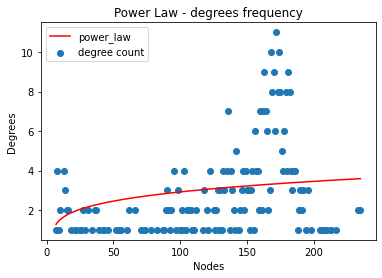



min degree =7
max degree =235
1 nodes have minimum degree centralities
2 nodes nodes have maximum degree centralities
max degree centrality  ENSMUSG00000000295
node with maximum degrees = Node 51 with num of degrees = 235
Propagation from point 51  affected 396 nodes


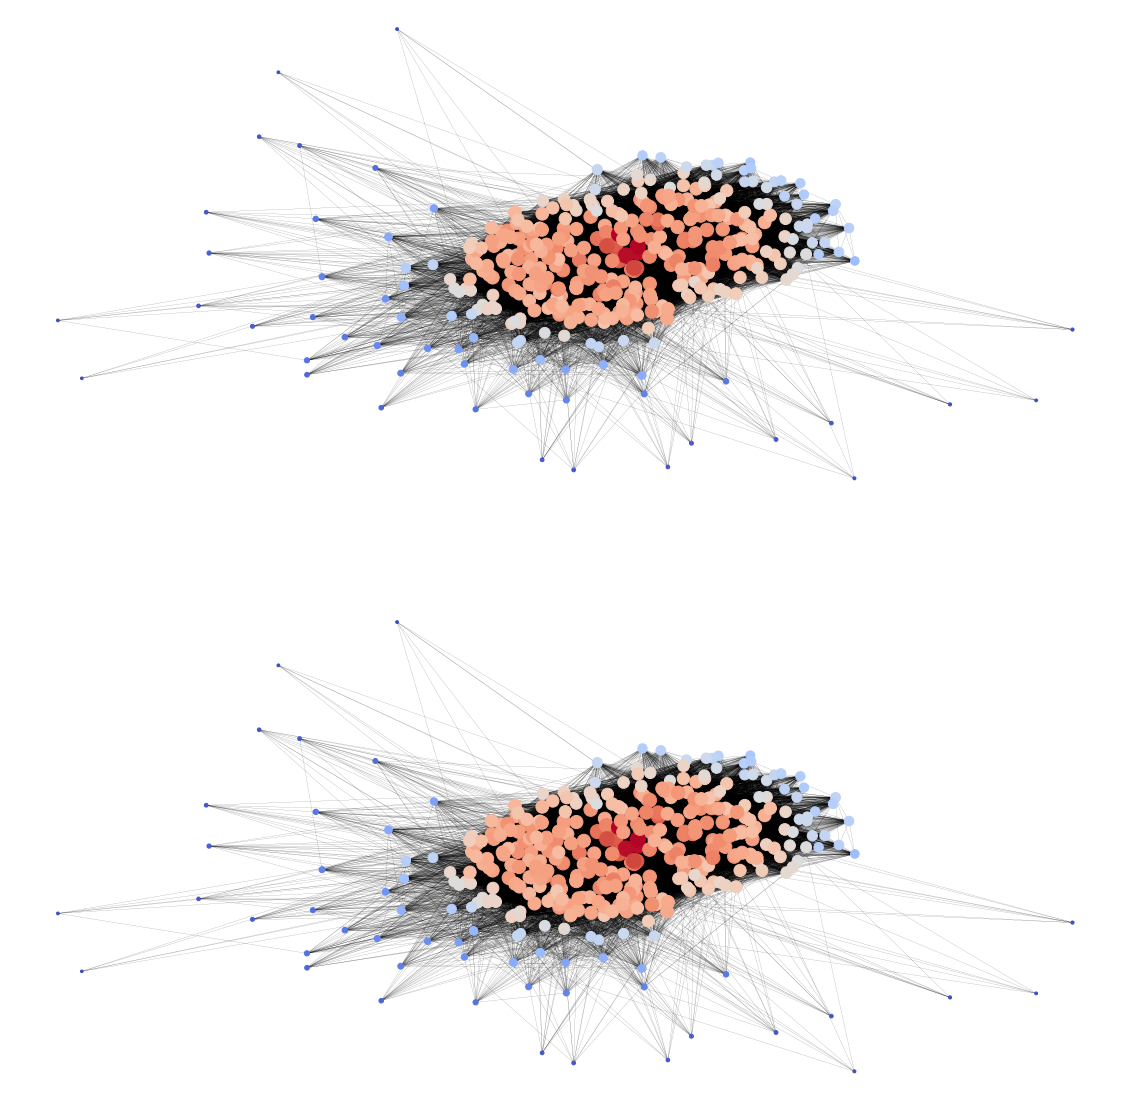

1 nodes have minimum betweenness centralities
1 nodes have maximum betweenness centralities
max betweeness centrality  ENSMUSG00000001095
max centrality node = 190 with value : 0.004537524938546833 and degree = 56


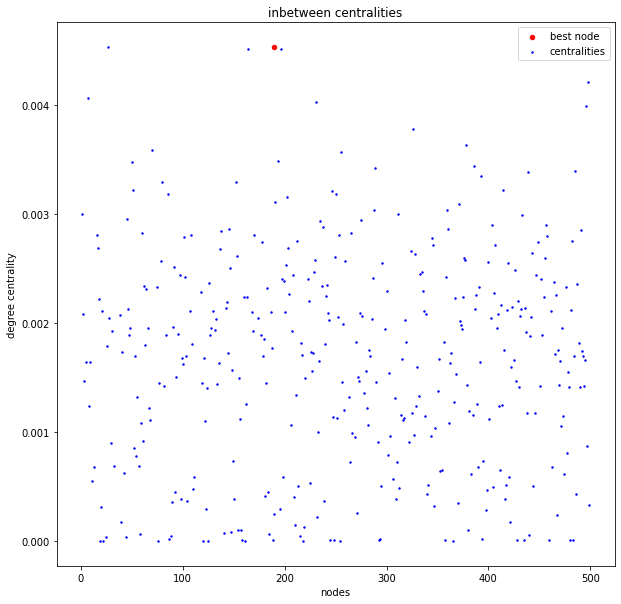

1 nodes have minimum closeness centralities
2 nodes have maximum closeness centralities
max closeness centralities =  ENSMUSG00000000295
max closeness centralities =  ENSMUSG00000001017
max closeness centrality node = 170 with value : 0.7091561938958707 and degree = 184


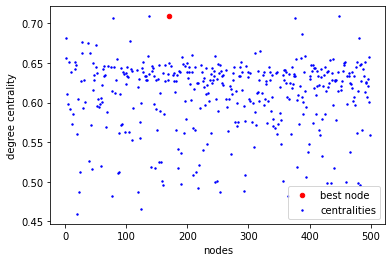

maximum page rank  = 0.0038941865202498753
best page rank node =  449
max pagerank centrality  ENSMUSG00000002588


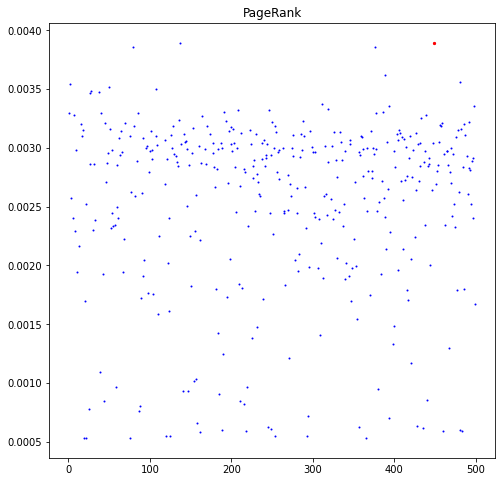

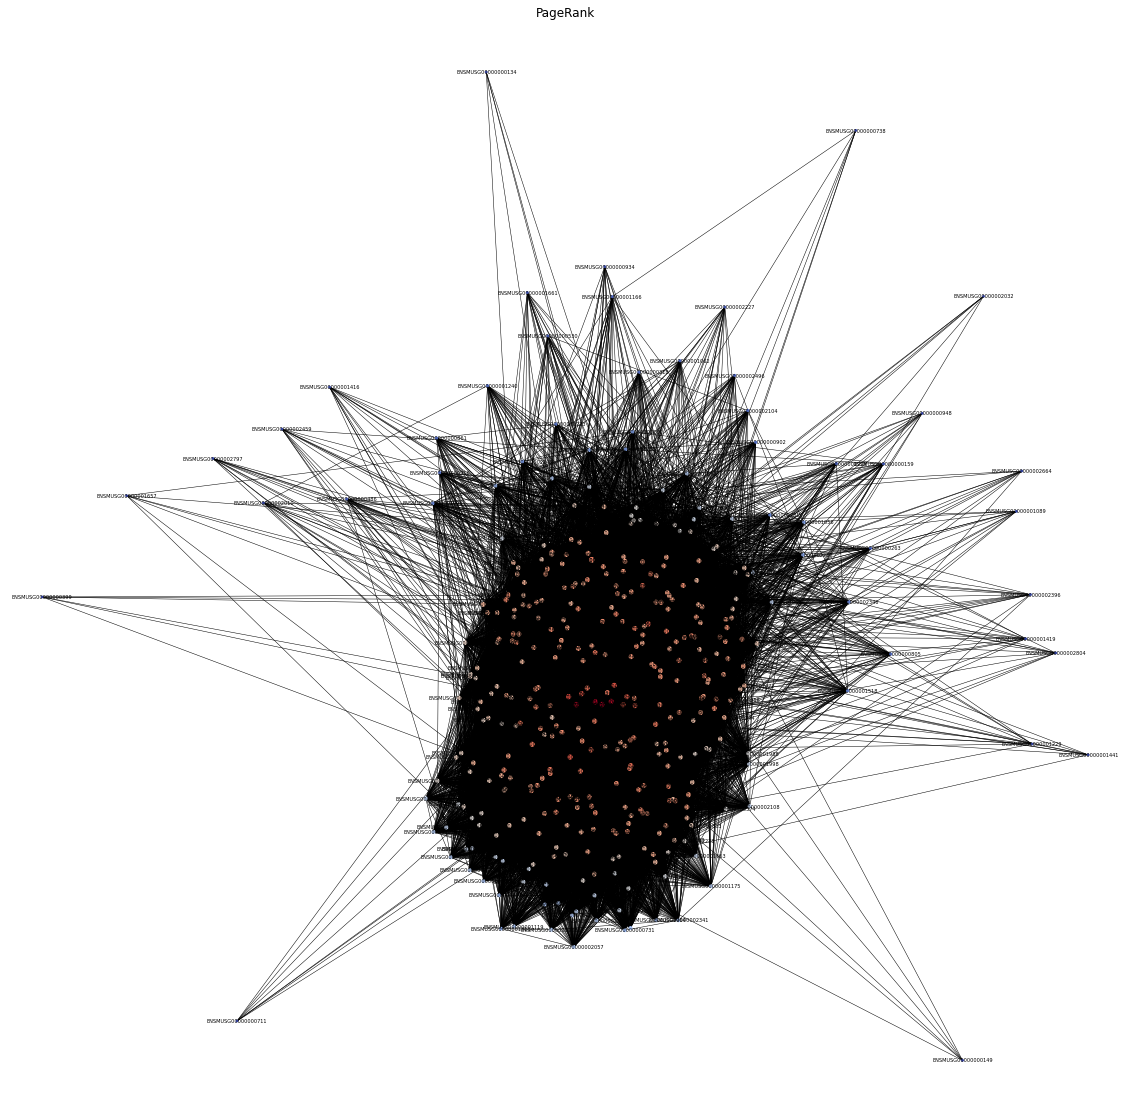

In [43]:
import csv

def construct_network(csv_file,annotation_file='',header_num=0):
  while True:
    dataset=pd.read_csv(csv_file,delimiter= ",",header=None)
    print(dataset)
    if list(dataset)[0] == '%':
        header_num += 1
    else:
        break
  arr = pandas.read_csv(annotation_file,delimiter=',')
  arr = arr.iloc[:500,:100]
  gene_labels = arr[arr.columns[0]]
  with open('labels.csv', 'w') as f:
      for line in gene_labels:
          f.write(line)
          f.write("\n")
  #500 genes x100 cells

  labels = {}
  for i in range(499):
    labels[i] = str(gene_labels[i])#'G'+str(gene_labels[i])[-4:]

  G = GeneNetwork(dataset)
  
  G.show_graph_info()
  G.show_degree_distribution()
  G.show_degree_centrality(labels=labels)
  G.show_betweeness_centrality(labels=labels)
  G.show_closeness_centrality(labels=labels)
  G.show_pagerank(labels=labels)


  


  #G.clustering()


def csn2edges(csv_file):
  dataset=pd.read_csv(csv_file,delimiter= ",",header=None)
  rowid = 0
  with open('edges.csv', 'w') as f:
    for index,row in dataset.iterrows():
      colid = 0
      source = str(index)
      for col in row:
        if col == 1:
          target = str(colid)
          f.write(source+','+target)
          f.write("\n")
        colid+=1
      
  

def main(run_ndm=False):
  if run_ndm:
    genes,expressions = get_scRNA(dataset='gea_norm.csv')
    print('(genes,cells) = ',expressions.shape)
    ndm = csndm(data=expressions[:500,:100])
    dataset = np.asarray(ndm)
    csv_file = "ndm.csv"
    np.savetxt(csv_file, dataset, delimiter=",")
  csn2edges('/content/ReprCSN.csv')
  construct_network("/content/edges.csv",'/content/gea_norm.csv')
  

if __name__ == "__main__":
    main(run_ndm=False)


